In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 1

#Times to evaluate the solution
data = make_test_data_1()
times = data['t']
# times = np.arange(0.25,8,0.25)

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_1, 
                    t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

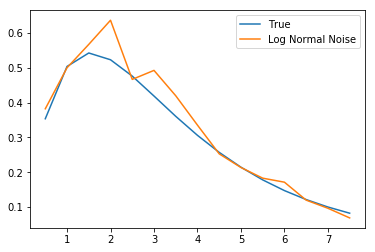

In [3]:

Ytrue = data['y']
Y = data['yobs']

plt.plot(times, Ytrue, label = 'True')
plt.plot(times, Y, label = 'Log Normal Noise')

plt.legend()

In [4]:
# my_ODEop = ODEop(ode_model)

In [5]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha',1)

    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    # [ODE parameter, Initial Condition]
    all_params = pm.math.stack([alpha, 0],axis=0)

    
    ode_sol = ode_model(all_params)

    forward = ode_sol.reshape(Y.shape)
    
    ode = pm.Deterministic('ode',ode_sol)
        
    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [03:03<00:00, 32.77draws/s]


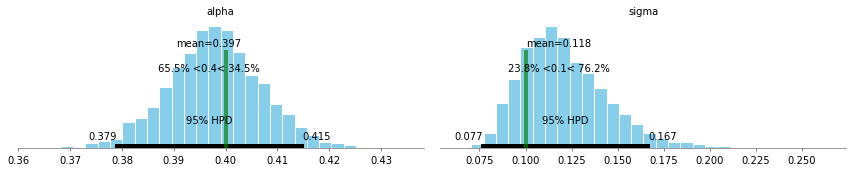

In [12]:
alpha = data['p'][0]
y0 = 0
sigma = data['sigma']
pm.posteriorplot.plot_posterior(trace,varnames = ['alpha','sigma'], ref_val=[alpha, sigma]);

In [13]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

{'alpha': 0.999986377920498,
 'ode': array([0.99998597, 0.99998555, 0.9999851 , 0.99998463, 0.99998414,
       0.99998364, 0.99998311, 0.99998257, 0.99998201, 0.99998144,
       0.99998085, 0.99998025, 0.99997964, 0.99997901, 0.99997837]),
 'sigma': 0.9998120759283685}
{'alpha': 3205.813294435321,
 'ode': array([3206.57452968, 3207.338147  , 3208.09752479, 3208.8462028 ,
       3209.57801385, 3210.28716758, 3210.96829399, 3211.61649087,
       3212.22733234, 3212.79686659, 3213.32158107, 3213.79840939,
       3214.22465494, 3214.59801102, 3214.91653198]),
 'sigma': 2689.15658337753}


In [14]:
with first_model:
    ppc = pm.sample_ppc(trace, 100)

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 100/100 [00:01<00:00, 90.28it/s]


Text(0.5, 1.0, 'Posterior Predictive Check')

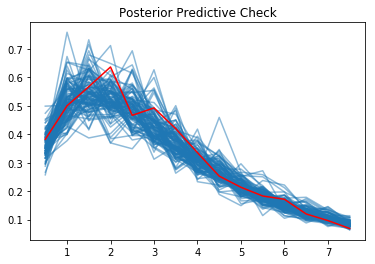

In [15]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5);
    
plt.plot(times,Y, color = 'red');
plt.title('Posterior Predictive Check')

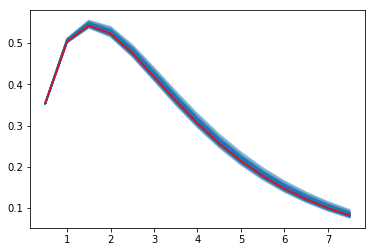

In [16]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.25);
    
plt.plot(times,Ytrue, color = 'red');

In [11]:
%timeit ode_model.cached_simulate([np.random.uniform(),0])

11.7 ms ± 871 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
